## FADM-GPS : Frequency attributed diffusion model for generating pulsatile signals 

In [1]:
import os
import copy
import numpy as np
import yaml
from tqdm import trange, tqdm
from functools import reduce
from scipy import stats
from itertools import count

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from Models.MainModel import *
from Models.Discriminator import FacDiscriminator
from Utilities.Utilities import *
from Utilities.EvaluationModules import *
from Models.Losses import *

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

def read_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

#### Env setting

In [2]:
ConfigName = 'SKZFC_ART_50_800_RE'
ReparaStd = 1
ReparaStdZj = 1
BatchSize = 10000

if 'ART' in ConfigName:
    LoadConfig = 'Config' + 'ART'
elif 'PLETH' in ConfigName:
    LoadConfig = 'Config' + 'PLETH'
elif 'II' in ConfigName:
    LoadConfig = 'Config' + 'II'
else:
    assert False, "Please verify if the data type is properly included in the name of the configuration. The configuration name should be structured as 'Config' + 'data type', such as ConfigART."

#yaml_path = './Config/'+LoadConfig+'.yml'
#SavePath = './Results/'

yaml_path = './Config/'+LoadConfig+'800.yml'
SavePath = './Results/'
ConfigSet = read_yaml(yaml_path)

### Model related parameters
SigType = ConfigSet[ConfigName]['SigType']
LatDim = ConfigSet[ConfigName]['LatDim']
CompSize = ConfigSet[ConfigName]['CompSize']
LossType = ConfigSet[ConfigName]['LossType']
FcLimit = ConfigSet[ConfigName]['FcLimit']


ModelName = ConfigName+'.hdf5'
### Model checkpoint
ModelSaveName = SavePath+ModelName


### Data

In [3]:
TrData = np.load('./Data/ProcessedData/Tr'+str(SigType)+'.npy')
ValData = np.load('./Data/ProcessedData/Val'+str(SigType)+'.npy')

SigDim = ValData.shape[1]
DataSize = ValData.shape[0]

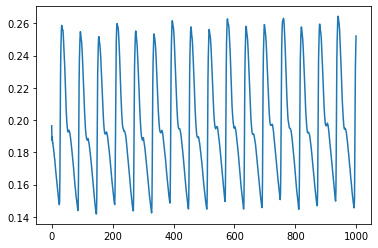

In [4]:
plt.plot(ValData[9])

### Post model

In [4]:
# Defining Modesl
EncModel = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', ReparaStd = ReparaStd, Reparam=True, FcLimit=FcLimit)
FeatExtModel = FeatExtractor(SigDim=SigDim, CompSize = CompSize)
FeatGenModel = FeatGenerator(SigDim=SigDim,CompSize=CompSize, LatDim= LatDim)
ReconModel = Reconstructor(SigDim=SigDim, CompSize=CompSize)

Models = [EncModel,FeatExtModel,FeatGenModel,ReconModel] 

# Adding losses
if LossType =='TCLosses':
    Models = [EncModel,FeatExtModel,FeatGenModel,ReconModel] 
    SigRepModel = TCLosses(Models, DataSize, ConfigSet[ConfigName])

elif LossType =='FACLosses':
    DiscHiddenSize = ConfigSet[ConfigName]['DiscHiddenSize']
    FacDiscModel = FacDiscriminator(LatDim, DiscHiddenSize)
    Models = [EncModel,FeatExtModel,FeatGenModel,ReconModel, FacDiscModel] 
    SigRepModel = FACLosses(Models, ConfigSet[ConfigName])


### Load weights
SigRepModel.load_weights(ModelSaveName)

### Regularizer resetting
for i in SigRepModel.weights:
    if i.name.split('/')[0] in ['Beta_Z','Beta_Fc','Beta_TC', 'Beta_MI' ,'Beta_Orig', 'Beta_Feat']:
        i.assign(1.)
        
## Model Compile
SigRepModel.compile(optimizer='adam') 
SigRepModel.summary()

## The model for evaluation
RecOut = ReconModel(FeatGenModel.output)
GenModel = Model(FeatGenModel.input, RecOut)

## Sampling model
Zs_Out = SigRepModel.get_layer('Zs').output
SampModel = Model(EncModel.input, Zs_Out)


OrigRecLoss added
FeatRecLoss added
kl_Loss_SKZ selected
kl_Loss_Z added
kl_Loss_FC added
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp_Enc (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame (TFOpLambda)    (None, 20, 50)       0           Inp_Enc[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20, 50)       11550       tf.signal.frame[0][0]            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 50)       11550       bidirectional[0][0]              
____

In [5]:
# Power spectral density 
def FFT_PSD (Data, ReducedAxis, MinFreq = 1, MaxFreq = 51):
    # Dimension check; this part operates with 3D tensors.
    # (Batch_size, N_sample, N_frequency)
    Data = Data[:,None] if len(Data.shape) < 3 else Data

    # Power Spectral Density
    HalfLen = Data.shape[-1]//2
    FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen])[..., MinFreq:MaxFreq]
    # (Batch_size, N_sample, N_frequency)
    PSD = (FFTRes**2)/Data.shape[-1]

    # Probability Density Function
    if ReducedAxis == 'All':
        AggPSD = np.mean(PSD, axis=(0,1))
        # (N_frequency,)
        AggPSPDF = AggPSD / np.sum(AggPSD, axis=(-1),keepdims=True)
    
    elif ReducedAxis =='Sample':
        AggPSD = np.mean(PSD, axis=(1))
        # (Batch_size, N_frequency)
        AggPSPDF = AggPSD / np.sum(AggPSD, axis=(-1),keepdims=True)
    
    elif ReducedAxis == 'None':
        # (Batch_size, N_sample, N_frequency)
        AggPSPDF = PSD / np.sum(PSD, axis=(-1),keepdims=True)    
        
    return AggPSPDF


# Permutation entropy given PSD over each generation
def ProbPermutation(Data, WindowSize=3):
    # Data shape: (Batch_size, N_frequency, N_sample)
    
    # Generate true permutation cases
    TruePerms = np.concatenate(list(itertools.permutations(np.arange(WindowSize)))).reshape(-1, WindowSize)

    # Get all permutation cases
    Data_Ext = tf.signal.frame(Data, frame_length=WindowSize, frame_step=1, axis=-1)
    PermsTable =  np.argsort(Data_Ext, axis=-1)

    CountPerms = 1- (TruePerms[None,None,None] == PermsTable[:,:,:, None])
    CountPerms = 1-np.sum(CountPerms, axis=-1).astype('bool')
    CountPerms = np.sum(CountPerms, axis=(2))
    
    # Data shape: (Batch_size, N_frequency, N_permutation_cases)
    ProbCountPerms = CountPerms / np.sum(CountPerms, axis=-1, keepdims=True)
    
    return np.maximum(ProbCountPerms, 1e-7)    


def MeanKLD(P,Q):
    return np.mean(np.sum(P*np.log(P/Q), axis=-1))


def Sampler (Data, SampModel,BatchSize=100, GPU=True):
    if GPU==False:
        with tf.device('/CPU:0'):
            PredVal = SampModel.predict(Data, batch_size=BatchSize, verbose=1)   
    else:
        PredVal = SampModel.predict(Data, batch_size=BatchSize, verbose=1)   

    return PredVal


def SamplingZ (Data, SampModel, NMiniBat, NGen, BatchSize = 1000, GPU=True, SampZType='Model'):
    
    '''
    Sampling Samp_Z 

    - Shape of UniqSamp_Z: (NMiniBat, LatDim)
    - UniqSamp_Z ~ N(Zμ|y, σ) for Type =='Model'
    - RandSamp_Z ~ N(0, ReparaStdZj) for Type =='Random'

    - Samp_Z is a 3D tensor expanded by repeating the first axis (i.e., 0) of UniqSamp_Z or RandSamp_Z by NGen times.
    - Shape of Samp_Z: (NMiniBat, NGen, LatDim) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 
    '''
    
    # Sampling Samp_Z
    if SampZType =='Model': # Z ~ N(Zμ|y, σ)
        UniqSamp_Z = Sampler(Data, SampModel, GPU=True)
        Samp_Z =  np.broadcast_to(UniqSamp_Z[:, None], (NMiniBat, NGen, UniqSamp_Z.shape[-1])).reshape(-1, UniqSamp_Z.shape[-1])
    
    elif SampZType =='Random': # Z ~ N(0, ReparaStdZj)
        RandSamp_Z = np.random.normal(0, ReparaStdZj, (NMiniBat , 50))
        Samp_Z = np.repeat(RandSamp_Z, NGen, axis=0)
    
    return Samp_Z


def SamplingZj (Samp_Z, NMiniBat, NGen, LatDim, NSelZ, Axis=1):
    
    '''
     Sampling Samp_Zj 

    - Masking is applied to select Samp_Zj from Samp_Z 
      by assuming that the Samp_Z with indices other than j have a fixed mean value of '0' following a Gaussian distribution.

    - Shape of Samp_Zj: (NMiniBat, NGen, LatDim) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 

    - Samp_Zj ~ N(Zμj|y, σj), j∼U(1,LatDim)
    - In the expression j∼U(1,LatDim), j corresponds to LatDim and all js are selected randomly.

    '''
    
    # Masking for selecting Samp_Zj from Samp_Z 
    if Axis ==1: #It is strongly recommended when there is no FC input or variations in FC values.
        Mask_Z = np.zeros((NMiniBat*NGen, LatDim))
        for i in range(NMiniBat*NGen):
            Mask_Z[i, np.random.choice(LatDim, NSelZ,replace=False )] = 1
            
    elif Axis ==2: # It is strongly recommended in cases where there are variations in FC values
        Mask_Z = np.zeros((NMiniBat, NGen, LatDim))
        for i in range(NMiniBat):
            Mask_Z[i, :, np.random.choice(LatDim, NSelZ,replace=False )] = 1
    
    # Selecting Samp_Zj from Samp_Z 
    Mask_Z = Mask_Z.reshape(NMiniBat*NGen, LatDim)
    Samp_Zj = Samp_Z * Mask_Z
    
    return Samp_Zj


        


In [37]:
class Evaluator ():
    
    def __init__ (self, MinFreq=1, MaxFreq=51,  SimSize = 1, NMiniBat=100, 
                  NGen=100, ReparaStdZj = 1, NSelZ = 1, SampBatchSize = 1000, GenBatchSize = 1000, GPU=True):
        
        # Optional parameters with default values
        self.MinFreq = MinFreq               # The minimum frequency value within the analysis range (default = 1).
        self.MaxFreq = MaxFreq               # The maximum frequency value within the analysis range (default = 51).
        self.SimSize = SimSize               # Then umber of simulation repetitions for aggregating metrics (default: 1)
        self.NMiniBat = NMiniBat             # The size of the mini-batch, splitting the task into N pieces of size NMiniBat.
        self.NGen = NGen                     # The number of generations (i.e., samplings) within the mini-batch.
        self.ReparaStdZj = ReparaStdZj       # The size of the standard deviation when sampling Zj (Samp_ZjRPT ~ N(0, ReparaStdZj)).
        self.NSelZ = NSelZ                   # The size of js to be selected at the same time when selecting Zj (default: 1).
        self.SampBatchSize = SampBatchSize   # The batch size during prediction of the sampling model.
        self.GenBatchSize= GenBatchSize      # The batch size during prediction of the generation model.
        self.GPU = GPU                       # GPU vs CPU during model predictions (i.e., for SampModel and GenModel).
        
    
    ''' ------------------------------------------------------ Ancillary Functions ------------------------------------------------------'''

    ### ----------- Searching for candidate Zj for plausible signal generation ----------- ###
    def LocCandZs (self, Mode_Value, SumH, Samp_Z, TrackerCandZ_Temp):
        
        for Freq, _ in self.BestZsMetrics.items():
            Mode_Idx = np.where(Mode_Value == Freq)[0]

            # Skipping the remainder of the code if there are no mode values present at the predefined frequencies.
            if len(Mode_Idx) <1: 
                continue;

            # Calculating the minimum of sum of H (Min_SumH) and Candidate Z-values(CandZs)
            Min_SumH_Idx = np.argmin(SumH[Mode_Idx])
            Min_SumH = np.min(SumH[Mode_Idx])
            CandZs = Samp_Z[[Mode_Idx[Min_SumH_Idx]]][0].flatten()
            CandZ_Idx = np.where(CandZs!=0)[0]

            #tracking results
            TrackerCandZ_Temp[Freq]['TrackZLOC'].append(CandZ_Idx[None])
            TrackerCandZ_Temp[Freq]['TrackZs'].append(CandZs[CandZ_Idx][None])
            TrackerCandZ_Temp[Freq]['TrackMetrics'].append(Min_SumH[None])

            # Updating the Min_SumH value if the current iteration value is smaller.
            if Min_SumH < self.BestZsMetrics[Freq][0]:
                self.BestZsMetrics[Freq] = [Min_SumH, CandZ_Idx, CandZs[CandZ_Idx]]
                print('Candidate Z updated! ', 'Freq:', Freq, ', SumH_ZjFa:', np.round(Min_SumH, 4) , 
                      ' Z LOC:', CandZ_Idx, ' Z:', np.round(CandZs[CandZ_Idx], 4))
        
        return TrackerCandZ_Temp

    
    ### --------------------- ## Selecting nested Z-LOC and Z values --------------------- ###
    def SubNestedZFix(self, SubTrackerCandZ , NSelZ=None):
        
        # Setting arguments
        NSelZ = self.NSelZ if NSelZ is None else NSelZ
        
        Cnt = count()
        Results = {next(Cnt):{ TrackZLOC[i] : TrackZs[i] for i in range(NSelZ)} 
                    for TrackZLOC,TrackZs, TrackMetrics 
                    in zip(SubTrackerCandZ['TrackZLOC'], SubTrackerCandZ['TrackZs'], SubTrackerCandZ['TrackMetrics'])
                    if TrackMetrics < MetricCut }
        return Results
    
    
    
    
    
    ''' ------------------------------------------------------ Main Functions ------------------------------------------------------'''
    
    ### ----------- Conditional Mutual Information to evaluate model performance ----------- ###
    def CondMI_ZFC (self, AnalData, SampModel, GenModel, FC_ArangeInp, FcLimit=0.05,  WindowSize=3, FCmuEps = 0.05, Continue=True, SampZType='Model'):
        
        ## Required parameters
        self.AnalData = AnalData             # The data to be used for analysis.
        self.SampModel = SampModel           # The model that samples Zs.
        self.GenModel = GenModel             # The model that generates signals based on given Zs and FCs.
        self.FC_ArangeInp = FC_ArangeInp     # The 2D matrix (N_sample, NFCs) containing FCs values that the user creates and inputs directly.
        
        
        ## Optional parameters with default values ##
        # FcLimit: The threshold value of the max of the FC value input into the generation model (default: 0.05, i.e., frequency 5 Hertz)
        # WindowSize: The window size when calculating permutation entropy (default: 3)
        # FCmuEps: The max threshold value of eps when performing a Monte Carlo simulation by adding eps ~ N(0, 0.5*FcLimit*FCmuEps) to FcMu (i.e., FcLimit * 0.5) (default: 0.05)
        # Continue: Start from the beginning (Continue = False) vs. Continue where left off (Continue = True)
        self.SampZType = SampZType  # Z~ N(Zμ|y, σ) (SampZType = 'Model') vs. Z ~ N(0, ReparaStdZj) (SampZType = 'Random')
              
            
        ## Intermediate variables
        self.Ndata = len(AnalData) # The dimension size of the data.
        self.NFCs = GenModel.get_layer('Inp_FCEach').output.shape[-1] + GenModel.get_layer('Inp_FCCommon').output.shape[-1] # The dimension size of FCs.
        self.LatDim = SampModel.output.shape[-1] # The dimension size of Z.
        self.SigDim = AnalData.shape[-1] # The dimension (i.e., length) size of the raw signal.
        self.SubIterSize = self.Ndata//self.NMiniBat
        self.TotalIterSize = self.SubIterSize * self.SimSize
        
        
        # Functional trackers
        if Continue == False or not hasattr(self, 'iter'):
            self.sim = 0
            self.mini =0
            self.iter = 0
        
            ## Result trackers
            self.SubResDic = {'I_zPSD_Z':[],'I_zPSD_ZjZ':[],'I_zPSD_ZjFc':[],'I_zPSD_FaZj':[],'I_fcPE_FcZj':[],'I_fcPE_FaZj':[]}
            self.AggResDic = {'I_zPSD_Z':[],'I_zPSD_ZjZ':[],'I_zPSD_ZjFc':[],'I_zPSD_FaZj':[],'I_fcPE_FcZj':[],'I_fcPE_FaZj':[], 
                         'CMI_zPSD_ZjZ':[], 'CMI_zPSD_FcZj':[], 'CMI_fcPE_FaFc':[]}
            self.BestZsMetrics = {i:[np.inf] for i in range(1, MaxFreq - MinFreq + 2)}
            TrackerCandZ_Temp = {i:{'TrackZLOC':[],'TrackZs':[],'TrackMetrics':[] } for i in range(1, MaxFreq - MinFreq + 2)} 
            self.I_zPSD_Z = 0
            self.I_zPSD_ZjZ = 0
            self.I_zPSD_ZjFc = 0
            self.I_zPSD_FaZj = 0
            self.I_fcPE_FcZj = 0
            self.I_fcPE_FaZj = 0
        
        
        
        ### ------------------------------------------------ Task logics ------------------------------------------------ ###
        
        # P(V=v)
        ## Data shape: (N_frequency)
        self.P_PSPDF = FFT_PSD(self.AnalData, 'All', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq)
        
        
        # Just functional code for setting the initial position of the progress bar 
        self.StartBarPoint = self.TotalIterSize*(self.iter/self.TotalIterSize) 
        with trange(self.iter, self.TotalIterSize , initial=self.StartBarPoint, leave=False) as t:

            for sim in range(self.sim, self.SimSize):
                self.sim = sim
                SplitData = np.array_split(self.AnalData, self.SubIterSize)
                
                for mini in range(self.mini, self.SubIterSize):
                    self.mini = mini
                    self.iter += 1
                    print()

                    ### ------------------------------------------------ Sampling ------------------------------------------------ ###
                    # Updating NMiniBat; If there is a remainder in Ndata/NMiniBat, NMiniBat must be updated." 
                    self.NMiniBat = len(SplitData[mini]) 
                
                    # Sampling Samp_Z 
                    self.Samp_Z = SamplingZ(SplitData[mini], self.SampModel, self.NMiniBat, self.NGen, 
                                       BatchSize = self.SampBatchSize, GPU=self.GPU, SampZType=self.SampZType)

                    # Selecting Samp_Zj from Samp_Z 
                    ## For Samp_Zj, j is selected randomly across both the j and generation axes.
                    self.Samp_Zj = SamplingZj (self.Samp_Z, self.NMiniBat, self.NGen, self.LatDim, self.NSelZ, Axis=1)
                    ## For Samp_ZjRPT, the same j is selected in all generations within a mini-batch.
                    self.Samp_ZjRPT = SamplingZj (self.Samp_Z, self.NMiniBat, self.NGen, self.LatDim, self.NSelZ, Axis=2)


                    
                    # Sampling FCs
                    ## Shape of FCs: (NMiniBat*NGen, LatDim) instead of (NMiniBat, NGen, NFCs) for optimal use of GPU
                    self.FCs = np.random.rand(self.NMiniBat * self.NGen, self.NFCs) * FcLimit
                    
                    # Generating FCμ: 
                    self.FCmu = np.zeros_like(self.FCs) + FcLimit * 0.5
                    
                    # Sampling FCμ: FCmu_Rand
                    # FCmu_Rand are sampled as FC_μ x FcLimit + eps, where FC_μ=0.5 and eps ~ N(0, 0.5*FcLimit*FCmuEps)
                    self.FCmu_Rand = np.zeros_like(self.FCs) + FcLimit * 0.5 + np.random.normal(0, (FcLimit * 0.5)*FCmuEps, (self.FCs.shape))
                    
                    # Generating FC values with a fixed interval that increases at equal increments.
                    self.FC_Arange = np.broadcast_to(self.FC_ArangeInp[None], (self.NMiniBat, self.NGen, self.NFCs)).reshape(-1, self.NFCs)
                    
                    
                    

                    ### ------------------------------------------------ Signal reconstruction ------------------------------------------------ ###
                    '''
                    - To maximize the efficiency of GPU utilization, 
                      we performed a binding operation on (NMiniBat, NGen, LatDim) for Zs and (NMiniBat, NGen, NFCs) for FCs, respectively, 
                      transforming them to (NMiniBat * NGen, LatDim) and (NMiniBat * NGen, NFCs). 
                      After the computation, we then reverted them back to their original dimensions.

                    '''
                    ## Binding the samples together, generate signals through the model 
                    Set_FCs = np.concatenate([self.FCmu,   self.FCmu,     self.FCs,         self.FC_Arange])
                    Set_Zs = np.concatenate([self.Samp_Z,  self.Samp_Zj,  self.Samp_ZjRPT,  self.Samp_ZjRPT])

                    
                    # Choosing GPU or CPU and generating signals
                    if self.GPU==False:
                        with tf.device('/CPU:0'):
                            Set_Pred = self.GenModel.predict([Set_FCs[:, :2], Set_FCs[:, 2:], Set_Zs], batch_size=self.GenBatchSize, verbose=1)                            
                    else:
                        Set_Pred = self.GenModel.predict([Set_FCs[:, :2], Set_FCs[:, 2:], Set_Zs], batch_size=self.GenBatchSize, verbose=1)
                    
                        
                    # Re-splitting predictions for each case
                    Set_Pred = Set_Pred.reshape(-1, self.NMiniBat, self.NGen, self.SigDim)
                    self.SigGen_Z, self.SigGen_Zj, self.SigGen_ZjRptFC, self.SigGen_ZjRptFCar = [np.squeeze(SubPred) for SubPred in np.split(Set_Pred, 4)]  
                    

                    
                    ### ---------------------------- Cumulative Power Spectral Density (PSD) over each frequency -------------------------------- ###
                    # Return shape: (Batch_size, N_frequency)
                    self.Q_PSPDF_Z = FFT_PSD(self.SigGen_Z, 'Sample', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq)
                    self.Q_PSPDF_Zj = FFT_PSD(self.SigGen_Zj, 'Sample', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq)
                    self.Q_PSPDF_ZjRptFC = FFT_PSD(self.SigGen_ZjRptFC, 'Sample', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq)
                    self.Q_PSPDF_ZjRptFCar = FFT_PSD(self.SigGen_ZjRptFCar, 'Sample', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq)
                    
                    # Return shape: (Batch_size, N_frequency, N_sample)
                    self.SubPSPDF_ZjRptFC = FFT_PSD(self.SigGen_ZjRptFC, 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq).transpose(0,2,1)
                    self.SubPSPDF_ZjRptFCar = FFT_PSD(self.SigGen_ZjRptFCar, 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq).transpose(0,2,1)
                    
                    # Return shape: (Batch_size, 1, N_frequency)
                    self.SubPSPDF_Batch = FFT_PSD(SplitData[mini][:,None], 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq)
                    self.SubPSPDF_Batch.sort(0)
                    
                    
                    ### ---------------------------- Permutation Entropy given PSD over each generation -------------------------------- ###
                    # Return shape: (Batch_size, N_frequency, N_permutation_cases)
                    self.Q_PEPDF_ZjRptFC = ProbPermutation(self.SubPSPDF_ZjRptFC, WindowSize=WindowSize)
                    self.Q_PEPDF_ZjRptFCar = ProbPermutation(self.SubPSPDF_ZjRptFCar, WindowSize=WindowSize)
                    self.Q_PEPDF_Batch = ProbPermutation(self.SubPSPDF_Batch, WindowSize=WindowSize)
                    

                    ### ---------------------------------------- Conditional mutual information ---------------------------------------- ###
                    # zPSD and fcPE stand for z-wise power spectral density and fc-wise permutation entropy, respectively.
                    I_zPSD_Z_ = MeanKLD(self.Q_PSPDF_Z, self.P_PSPDF[None] ) # I(zPSD;Z)
                    I_zPSD_ZjZ_ = MeanKLD(self.Q_PSPDF_Zj, self.Q_PSPDF_Z )  # I(zPSD;Zj|Z)
                    I_zPSD_ZjFc_ =  MeanKLD(self.Q_PSPDF_ZjRptFC, self.P_PSPDF[None] ) # I(zPSD;Zj)
                    I_zPSD_FaZj_ = MeanKLD(self.Q_PSPDF_ZjRptFCar, self.Q_PSPDF_ZjRptFC ) # I(zPSD;FC|Zj)
                    I_fcPE_FcZj_ = MeanKLD(self.Q_PEPDF_ZjRptFC, self.Q_PEPDF_Batch) # I(fcPE;Zj)
                    I_fcPE_FaZj_ = MeanKLD(self.Q_PEPDF_ZjRptFCar, self.Q_PEPDF_ZjRptFC) # I(fcPE;FC|Zj)


                    print('I_zPSD_Z :', I_zPSD_Z_)
                    self.SubResDic['I_zPSD_Z'].append(I_zPSD_Z_)
                    self.I_zPSD_Z += I_zPSD_Z_

                    print('I_zPSD_ZjZ :', I_zPSD_ZjZ_)
                    self.SubResDic['I_zPSD_ZjZ'].append(I_zPSD_ZjZ_)
                    self.I_zPSD_ZjZ += I_zPSD_ZjZ_

                    print('I_zPSD_ZjFc :', I_zPSD_ZjFc_)
                    self.SubResDic['I_zPSD_ZjFc'].append(I_zPSD_ZjFc_)
                    self.I_zPSD_ZjFc += I_zPSD_ZjFc_

                    print('I_zPSD_FaZj :', I_zPSD_FaZj_)
                    self.SubResDic['I_zPSD_FaZj'].append(I_zPSD_FaZj_)
                    self.I_zPSD_FaZj += I_zPSD_FaZj_

                    print('I_fcPE_FcZj :', I_fcPE_FcZj_)
                    self.SubResDic['I_fcPE_FcZj'].append(I_fcPE_FcZj_)
                    self.I_fcPE_FcZj += I_fcPE_FcZj_

                    print('I_fcPE_FaZj :', I_fcPE_FaZj_)
                    self.SubResDic['I_fcPE_FaZj'].append(I_fcPE_FaZj_)
                    self.I_fcPE_FaZj += I_fcPE_FaZj_

                    
                    
                    
                    ### --------------------------- Locating the candidate Z values that generate plausible signals ------------------------- ###
                    self.H_zPSD_ZjFa = -np.sum(self.Q_PSPDF_ZjRptFCar * np.log(self.Q_PSPDF_ZjRptFCar), axis=-1)
                    self.H_fcPE_ZjFa = np.mean(-np.sum(self.Q_PEPDF_ZjRptFCar * np.log(self.Q_PEPDF_ZjRptFCar), axis=-1), axis=-1)
                    self.SumH_ZjFa = self.H_zPSD_ZjFa + self.H_fcPE_ZjFa
                    
                    # Calculating the mode-maximum frequency given the PSD from SigGen_ZjRptFCar.
                    # Return shape: (Batch_size, N_sample, N_frequency)
                    self.Q_PSPDF_ZjRptFCar_Local = FFT_PSD(self.SigGen_ZjRptFCar, 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq)
                    
                    # The 0 frequency is excluded as it represents the constant term; by adding 1 to the index, the frequency and index can be aligned to be the same.
                    # Return shape: (Batch_size, N_sample)
                    Max_Freq_Label = np.argmax(self.Q_PSPDF_ZjRptFCar_Local, axis=-1) + 1
                    
                    # Return shape: (Batch_size, )
                    ModeMax_Freq = mode(Max_Freq_Label.T, axis=0, keepdims=False)[0]
                    
                    UniqSamp_Zj = self.Samp_ZjRPT.reshape(self.NMiniBat, self.NGen, -1)[:, 0]
                    TrackerCandZ_Temp = self.LocCandZs ( ModeMax_Freq, self.SumH_ZjFa, UniqSamp_Zj, TrackerCandZ_Temp)
                    
                    # Restructuring TrackerCandZ
                    self.TrackerCandZ = {item[0]: {'TrackZLOC': np.concatenate(TrackerCandZ_Temp[item[0]]['TrackZLOC']), 
                                           'TrackZs': np.concatenate(TrackerCandZ_Temp[item[0]]['TrackZs']), 
                                           'TrackMetrics': np.concatenate(TrackerCandZ_Temp[item[0]]['TrackMetrics'])} 
                                             for item in TrackerCandZ_Temp.items() if len(item[1]['TrackZLOC']) > 0} 

                    t.update(1)
                    

        # CMI(V;Zj, Z)
        self.I_zPSD_Z /= (self.TotalIterSize)
        self.AggResDic['I_zPSD_Z'].append(self.I_zPSD_Z)
        self.I_zPSD_ZjZ /= (self.TotalIterSize)
        self.AggResDic['I_zPSD_ZjZ'].append(self.I_zPSD_ZjZ)
        self.CMI_zPSD_ZjZ = self.I_zPSD_Z + self.I_zPSD_ZjZ             
        self.AggResDic['CMI_zPSD_ZjZ'].append(self.CMI_zPSD_ZjZ)

        # CMI(V;FC,Zj)
        self.I_zPSD_ZjFc /= (self.TotalIterSize)
        self.AggResDic['I_zPSD_ZjFc'].append(self.I_zPSD_ZjFc)
        self.I_zPSD_FaZj /= (self.TotalIterSize)
        self.AggResDic['I_zPSD_FaZj'].append(self.I_zPSD_FaZj)
        self.CMI_zPSD_FcZj = self.I_zPSD_ZjFc + self.I_zPSD_FaZj       
        self.AggResDic['CMI_zPSD_FcZj'].append(self.CMI_zPSD_FcZj)

        # CMI(VE;FC,Zj)
        self.I_fcPE_FcZj /= (self.TotalIterSize)
        self.AggResDic['I_fcPE_FcZj'].append(self.I_fcPE_FcZj)
        self.I_fcPE_FaZj /= (self.TotalIterSize)
        self.AggResDic['I_fcPE_FaZj'].append(self.I_fcPE_FaZj)
        self.CMI_fcPE_FaFc = self.I_fcPE_FcZj + self.I_fcPE_FaZj    
        self.AggResDic['CMI_fcPE_FaFc'].append(self.CMI_fcPE_FaFc)

    

    ### ------------------- Selecting post-sampled Z values for generating plausible signals ------------------- ###
    def SelPostSamp_Zj (self, MetricCut=np.inf, BestZsMetrics=None, TrackerCandZ=None, NSelZ=None, InterDataSave=True ):
        
        ## Optional parameters
        # MetricCut: The threshold value for selecting Zs whose Entropy of PSD (i.e., SumH) is less than the MetricCut

        # Setting arguments
        BestZsMetrics = self.BestZsMetrics if BestZsMetrics is None else BestZsMetrics
        TrackerCandZ = self.TrackerCandZ if TrackerCandZ is None else TrackerCandZ
        NSelZ = self.NSelZ if NSelZ is None else NSelZ
                
        # Exploring FreqIDs available for signal generation  
        CandFreqIDs = [item[0] for item in BestZsMetrics.items() if (item[1][0] != np.inf) and (item[1][0] < MetricCut)]

        # Selecting nested Z-LOC and Z values
        self.NestedZFix = {FreqID : self.SubNestedZFix(TrackerCandZ[FreqID], ) for FreqID in CandFreqIDs}

        # Creating a tensor of Z values for signal generation
        PostSamp_Zj = []
        for SubZFix in self.NestedZFix.items():
            for item in SubZFix[1].items():
                Mask_Z = np.zeros((LatDim))
                Mask_Z[list(item[1].keys())] =  list(item[1].values())
                PostSamp_Zj.append(Mask_Z[None])
        self.PostSamp_Zj = np.concatenate(PostSamp_Zj, axis=0)
        
        
        # Counting the number of obs in NestedZs
        NPostZs =0 
        for item in self.NestedZFix.items():
            NPostZs += len(item[1])

        print('The total number of sets in NestedZs:', NPostZs)

        
        # Saving intermedicate results into the hard disk
        if InterDataSave ==True:
            np.save('./Data/IntermediateData/PostSamp_Zj_'+str(SigType)+'_'+str(NSelZ)+'.npy', PostSamp_Zj) # Save data

        return self.PostSamp_Zj, self.NestedZFix

In [38]:
MaxFreq = 51
MinFreq = 1
NMiniBat = 100
SimSize = 1
FcLimit=0.05
NGen = 100
Ndata = len(ValData)
MASize = Ndata//NMiniBat
AnalData = ValData
NFCs = SigRepModel.get_layer('FCs').output.shape[-1]
NSelZ = 1
FCmuEps = 0.05
WindowSize=3

Eval = Evaluator(MinFreq=MinFreq, MaxFreq=MaxFreq, SimSize = SimSize, NMiniBat=NMiniBat, 
                  NGen=NGen, ReparaStdZj = 1, NSelZ = NSelZ, SampBatchSize = 100000, GenBatchSize = 100000, GPU=True)

### Calculating and tracking the Conditional Mutual Information metric

In [39]:
# FC_ArangeInp: A 2D matrix (NGen, NFCs) containing FCs values that the user creates and inputs directly.
MinFreqR=0. # Minimum value when generating FC_ArangeInp with linspace.
MaxFreqR=0.05 # Maximum value when generating FC_ArangeInp with linspace.
FC_ArangeInp = np.tile(np.linspace(MinFreqR, MaxFreqR, NGen )[:, None], (1,NFCs))


Eval.CondMI_ZFC(ValData[:10000], SampModel, GenModel, FC_ArangeInp, FcLimit=FcLimit,  WindowSize=WindowSize, FCmuEps =FCmuEps, Continue=False, SampZType='Model')
Eval1 = copy.copy(Eval)


  0%|                                                                                        | 0.0/100 [00:00<?, ?it/s]


1/1 [==============================] - 0s 171ms/step


  1%|▊                                                                               | 1.0/100 [00:01<02:14,  1.36s/it]

I_zPSD_Z : 1.9456813109248536
I_zPSD_ZjZ : 3.4076396685732186
I_zPSD_ZjFc : 1.4245380701462553
I_zPSD_FaZj : 0.019763398818385278
I_fcPE_FcZj : 0.13894707612507318
I_fcPE_FaZj : 0.7026991306355196
Updated!  Freq: 11 , SumH_ZjFa: 2.9961  Z LOC: [47]  Z: [1.4341]
Updated!  Freq: 12 , SumH_ZjFa: 2.3276  Z LOC: [44]  Z: [1.6637]
Updated!  Freq: 13 , SumH_ZjFa: 2.7118  Z LOC: [23]  Z: [-1.2383]
Updated!  Freq: 14 , SumH_ZjFa: 1.734  Z LOC: [5]  Z: [-0.4825]
Updated!  Freq: 15 , SumH_ZjFa: 1.9838  Z LOC: [11]  Z: [0.3095]
Updated!  Freq: 16 , SumH_ZjFa: 2.2092  Z LOC: [24]  Z: [1.8398]
Updated!  Freq: 17 , SumH_ZjFa: 2.1935  Z LOC: [26]  Z: [1.3714]
Updated!  Freq: 18 , SumH_ZjFa: 2.9446  Z LOC: [48]  Z: [1.8966]
Updated!  Freq: 19 , SumH_ZjFa: 2.6094  Z LOC: [12]  Z: [-1.3375]

1/1 [==============================] - 0s 168ms/step


  2%|█▌                                                                              | 2.0/100 [00:02<02:12,  1.36s/it]

I_zPSD_Z : 2.0279733116390615
I_zPSD_ZjZ : 3.3863603134875815
I_zPSD_ZjFc : 1.4296913219085052
I_zPSD_FaZj : 0.019429959424751328
I_fcPE_FcZj : 0.13214505540848992
I_fcPE_FaZj : 0.6986625586195395
Updated!  Freq: 11 , SumH_ZjFa: 2.0289  Z LOC: [1]  Z: [-0.9348]
Updated!  Freq: 14 , SumH_ZjFa: 1.7076  Z LOC: [12]  Z: [0.4251]
Updated!  Freq: 15 , SumH_ZjFa: 1.8347  Z LOC: [14]  Z: [-0.1647]
Updated!  Freq: 18 , SumH_ZjFa: 1.8828  Z LOC: [26]  Z: [1.8313]

1/1 [==============================] - 0s 179ms/step


  3%|██▍                                                                             | 3.0/100 [00:04<02:11,  1.36s/it]

I_zPSD_Z : 1.7708476871002368
I_zPSD_ZjZ : 3.2274334622053225
I_zPSD_ZjFc : 1.4749789264312412
I_zPSD_FaZj : 0.02094583597661058
I_fcPE_FcZj : 0.22037259612049298
I_fcPE_FaZj : 0.6952953198921463
Updated!  Freq: 10 , SumH_ZjFa: 1.8153  Z LOC: [3]  Z: [1.7657]
Updated!  Freq: 12 , SumH_ZjFa: 2.0499  Z LOC: [38]  Z: [1.9982]
Updated!  Freq: 13 , SumH_ZjFa: 2.683  Z LOC: [23]  Z: [-1.2951]
Updated!  Freq: 14 , SumH_ZjFa: 1.6743  Z LOC: [12]  Z: [0.4428]
Updated!  Freq: 15 , SumH_ZjFa: 1.5618  Z LOC: [21]  Z: [1.438]
Updated!  Freq: 20 , SumH_ZjFa: 3.2459  Z LOC: [23]  Z: [1.374]

1/1 [==============================] - 0s 192ms/step


  4%|███▏                                                                            | 4.0/100 [00:05<02:10,  1.36s/it]

I_zPSD_Z : 1.8885028541473707
I_zPSD_ZjZ : 3.345897874909972
I_zPSD_ZjFc : 1.394993274689333
I_zPSD_FaZj : 0.022303150654406353
I_fcPE_FcZj : 0.15801645745844276
I_fcPE_FaZj : 0.7076109219227109
Updated!  Freq: 11 , SumH_ZjFa: 1.965  Z LOC: [1]  Z: [-1.0153]
Updated!  Freq: 12 , SumH_ZjFa: 1.8587  Z LOC: [19]  Z: [-1.3295]
Updated!  Freq: 25 , SumH_ZjFa: 3.1297  Z LOC: [46]  Z: [-2.0169]

1/1 [==============================] - 0s 165ms/step


  5%|████                                                                            | 5.0/100 [00:06<02:08,  1.35s/it]

I_zPSD_Z : 1.813984709860118
I_zPSD_ZjZ : 3.1247117699631133
I_zPSD_ZjFc : 1.420009463711121
I_zPSD_FaZj : 0.02401538435071223
I_fcPE_FcZj : 0.1523862309224911
I_fcPE_FaZj : 0.698791225693483
Updated!  Freq: 8 , SumH_ZjFa: 2.6284  Z LOC: [8]  Z: [-2.0907]
Updated!  Freq: 13 , SumH_ZjFa: 2.6575  Z LOC: [23]  Z: [-1.3086]
Updated!  Freq: 17 , SumH_ZjFa: 2.0832  Z LOC: [46]  Z: [2.4134]
Updated!  Freq: 19 , SumH_ZjFa: 2.4608  Z LOC: [12]  Z: [-1.889]

1/1 [==============================] - 0s 164ms/step


  6%|████▊                                                                           | 6.0/100 [00:08<02:05,  1.34s/it]

I_zPSD_Z : 1.8608900100032884
I_zPSD_ZjZ : 3.363136424208889
I_zPSD_ZjFc : 1.412318354747208
I_zPSD_FaZj : 0.028548167566368528
I_fcPE_FcZj : 0.15987293403100003
I_fcPE_FaZj : 0.7015176131077192
Updated!  Freq: 16 , SumH_ZjFa: 1.8795  Z LOC: [4]  Z: [1.2312]
Updated!  Freq: 19 , SumH_ZjFa: 2.2236  Z LOC: [43]  Z: [0.995]

1/1 [==============================] - 0s 169ms/step


  7%|█████▌                                                                          | 7.0/100 [00:09<02:04,  1.34s/it]

I_zPSD_Z : 1.9004837558593033
I_zPSD_ZjZ : 3.365683659061475
I_zPSD_ZjFc : 1.4111526480576742
I_zPSD_FaZj : 0.034048478818502655
I_fcPE_FcZj : 0.1480922804496698
I_fcPE_FaZj : 0.6900944960285437
Updated!  Freq: 12 , SumH_ZjFa: 1.8378  Z LOC: [19]  Z: [-1.2862]
Updated!  Freq: 14 , SumH_ZjFa: 1.5335  Z LOC: [1]  Z: [1.0531]

1/1 [==============================] - 0s 164ms/step


  8%|██████▍                                                                         | 8.0/100 [00:10<02:02,  1.33s/it]

I_zPSD_Z : 1.8760682010195635
I_zPSD_ZjZ : 3.025404802651894
I_zPSD_ZjFc : 1.457852795393148
I_zPSD_FaZj : 0.025853989927662576
I_fcPE_FcZj : 0.16902929243702045
I_fcPE_FaZj : 0.6886077330128846
Updated!  Freq: 12 , SumH_ZjFa: 1.7844  Z LOC: [19]  Z: [-1.254]
Updated!  Freq: 13 , SumH_ZjFa: 2.1922  Z LOC: [29]  Z: [-2.3078]
Updated!  Freq: 16 , SumH_ZjFa: 1.755  Z LOC: [22]  Z: [-0.9055]

1/1 [==============================] - 0s 165ms/step


  9%|███████▏                                                                        | 9.0/100 [00:12<02:01,  1.33s/it]

I_zPSD_Z : 1.845288715007817
I_zPSD_ZjZ : 3.2395415195897193
I_zPSD_ZjFc : 1.4008781130361203
I_zPSD_FaZj : 0.02309569943723877
I_fcPE_FcZj : 0.11632260792939574
I_fcPE_FaZj : 0.7064201831714134
Updated!  Freq: 9 , SumH_ZjFa: 2.9596  Z LOC: [30]  Z: [2.0983]

1/1 [==============================] - 0s 166ms/step


 10%|███████▉                                                                       | 10.0/100 [00:13<01:59,  1.33s/it]

I_zPSD_Z : 2.050985978395986
I_zPSD_ZjZ : 3.6254363729877572
I_zPSD_ZjFc : 1.3955890232698565
I_zPSD_FaZj : 0.019280546790021513
I_fcPE_FcZj : 0.1680953462017945
I_fcPE_FaZj : 0.7003830668452192
Updated!  Freq: 11 , SumH_ZjFa: 1.9629  Z LOC: [14]  Z: [2.3832]

1/1 [==============================] - 0s 179ms/step


 11%|████████▋                                                                      | 11.0/100 [00:14<01:59,  1.34s/it]

I_zPSD_Z : 1.9650182831857623
I_zPSD_ZjZ : 3.363946268062108
I_zPSD_ZjFc : 1.3830910989235194
I_zPSD_FaZj : 0.0215566168040011
I_fcPE_FcZj : 0.13513079976446765
I_fcPE_FaZj : 0.7022105381994769

1/1 [==============================] - 0s 167ms/step


 12%|█████████▍                                                                     | 12.0/100 [00:16<01:58,  1.34s/it]

I_zPSD_Z : 1.845657868545016
I_zPSD_ZjZ : 3.040442107058981
I_zPSD_ZjFc : 1.383241041640007
I_zPSD_FaZj : 0.02671425310595442
I_fcPE_FcZj : 0.13005269148137946
I_fcPE_FaZj : 0.6935491667771192

1/1 [==============================] - 0s 171ms/step


 13%|██████████▎                                                                    | 13.0/100 [00:17<01:57,  1.35s/it]

I_zPSD_Z : 1.9556761934339644
I_zPSD_ZjZ : 3.2695706119592147
I_zPSD_ZjFc : 1.513825854287848
I_zPSD_FaZj : 0.024154291111121814
I_fcPE_FcZj : 0.19042751713147638
I_fcPE_FaZj : 0.6946992586563987
Updated!  Freq: 12 , SumH_ZjFa: 1.6842  Z LOC: [11]  Z: [2.5131]
Updated!  Freq: 19 , SumH_ZjFa: 2.2143  Z LOC: [43]  Z: [1.0132]

1/1 [==============================] - 0s 176ms/step


 14%|███████████                                                                    | 14.0/100 [00:18<01:57,  1.36s/it]

I_zPSD_Z : 1.8719218805536553
I_zPSD_ZjZ : 3.207976829470222
I_zPSD_ZjFc : 1.4102074002270937
I_zPSD_FaZj : 0.025266715956794358
I_fcPE_FcZj : 0.137899538222046
I_fcPE_FaZj : 0.7113748450632783

1/1 [==============================] - 0s 191ms/step


 15%|███████████▊                                                                   | 15.0/100 [00:20<01:55,  1.36s/it]

I_zPSD_Z : 1.84862569329657
I_zPSD_ZjZ : 3.222319773186007
I_zPSD_ZjFc : 1.4265470581045185
I_zPSD_FaZj : 0.03126169985301594
I_fcPE_FcZj : 0.1303830627740236
I_fcPE_FaZj : 0.6969501361923324
Updated!  Freq: 11 , SumH_ZjFa: 1.9626  Z LOC: [1]  Z: [-1.024]
Updated!  Freq: 19 , SumH_ZjFa: 2.2071  Z LOC: [43]  Z: [2.0573]

1/1 [==============================] - 0s 164ms/step


 16%|████████████▋                                                                  | 16.0/100 [00:21<01:53,  1.35s/it]

I_zPSD_Z : 1.8376226579633754
I_zPSD_ZjZ : 3.3765848729705574
I_zPSD_ZjFc : 1.4856935563889815
I_zPSD_FaZj : 0.021643598467199942
I_fcPE_FcZj : 0.17251518321444065
I_fcPE_FaZj : 0.7153367247246971
Updated!  Freq: 11 , SumH_ZjFa: 1.6158  Z LOC: [14]  Z: [2.6477]

1/1 [==============================] - 0s 164ms/step


 17%|█████████████▍                                                                 | 17.0/100 [00:22<01:51,  1.34s/it]

I_zPSD_Z : 1.926868321247649
I_zPSD_ZjZ : 3.4030691436494167
I_zPSD_ZjFc : 1.423521043123393
I_zPSD_FaZj : 0.020120370695852423
I_fcPE_FcZj : 0.18861270395350888
I_fcPE_FaZj : 0.7073132507764028
Updated!  Freq: 9 , SumH_ZjFa: 2.9007  Z LOC: [47]  Z: [-2.597]
Updated!  Freq: 10 , SumH_ZjFa: 1.7965  Z LOC: [3]  Z: [1.7372]

1/1 [==============================] - 0s 163ms/step


 18%|██████████████▏                                                                | 18.0/100 [00:24<01:50,  1.34s/it]

I_zPSD_Z : 1.852070483696361
I_zPSD_ZjZ : 3.1837364625582505
I_zPSD_ZjFc : 1.4490459221450969
I_zPSD_FaZj : 0.02109993473305767
I_fcPE_FcZj : 0.2541216380988021
I_fcPE_FaZj : 0.6909464677875018
Updated!  Freq: 15 , SumH_ZjFa: 1.5295  Z LOC: [21]  Z: [1.5917]
Updated!  Freq: 25 , SumH_ZjFa: 3.1241  Z LOC: [46]  Z: [-2.2219]

1/1 [==============================] - 0s 169ms/step


 19%|███████████████                                                                | 19.0/100 [00:25<01:48,  1.34s/it]

I_zPSD_Z : 1.9534614869610658
I_zPSD_ZjZ : 3.537041647191186
I_zPSD_ZjFc : 1.4498764063046556
I_zPSD_FaZj : 0.023133242241620944
I_fcPE_FcZj : 0.19991271961126036
I_fcPE_FaZj : 0.6873630580020553
Updated!  Freq: 14 , SumH_ZjFa: 1.3898  Z LOC: [1]  Z: [1.1435]

1/1 [==============================] - 0s 164ms/step


 20%|███████████████▊                                                               | 20.0/100 [00:26<01:46,  1.33s/it]

I_zPSD_Z : 1.9245530160858237
I_zPSD_ZjZ : 3.178930562396471
I_zPSD_ZjFc : 1.411592764012008
I_zPSD_FaZj : 0.021101428915613174
I_fcPE_FcZj : 0.24146166544031095
I_fcPE_FaZj : 0.6981771052586008

1/1 [==============================] - 0s 166ms/step


 21%|████████████████▌                                                              | 21.0/100 [00:28<01:44,  1.33s/it]

I_zPSD_Z : 1.8295265825304006
I_zPSD_ZjZ : 3.1934625234151057
I_zPSD_ZjFc : 1.4104279156829636
I_zPSD_FaZj : 0.021338232165600005
I_fcPE_FcZj : 0.24235254102281814
I_fcPE_FaZj : 0.7100147690701397
Updated!  Freq: 9 , SumH_ZjFa: 2.8134  Z LOC: [37]  Z: [-2.1294]

1/1 [==============================] - 0s 162ms/step


 22%|█████████████████▍                                                             | 22.0/100 [00:29<01:43,  1.33s/it]

I_zPSD_Z : 1.9439184038868678
I_zPSD_ZjZ : 3.5115578827766587
I_zPSD_ZjFc : 1.4197694281784452
I_zPSD_FaZj : 0.026135370249379092
I_fcPE_FcZj : 0.20946052863555778
I_fcPE_FaZj : 0.7021421818809854

1/1 [==============================] - 0s 166ms/step


 23%|██████████████████▏                                                            | 23.0/100 [00:30<01:42,  1.33s/it]

I_zPSD_Z : 1.9074576658454938
I_zPSD_ZjZ : 3.362483943739257
I_zPSD_ZjFc : 1.3613236080020295
I_zPSD_FaZj : 0.029442665299927954
I_fcPE_FcZj : 0.14790909659738694
I_fcPE_FaZj : 0.7072046247529383
Updated!  Freq: 21 , SumH_ZjFa: 3.0817  Z LOC: [16]  Z: [3.1901]

1/1 [==============================] - 0s 166ms/step


 24%|██████████████████▉                                                            | 24.0/100 [00:32<01:41,  1.33s/it]

I_zPSD_Z : 1.981857437874485
I_zPSD_ZjZ : 3.492376812645242
I_zPSD_ZjFc : 1.4295807321919631
I_zPSD_FaZj : 0.02459093768835723
I_fcPE_FcZj : 0.18221462451841985
I_fcPE_FaZj : 0.7131846786931301
Updated!  Freq: 7 , SumH_ZjFa: 3.1357  Z LOC: [6]  Z: [2.3882]

1/1 [==============================] - 0s 176ms/step


 25%|███████████████████▊                                                           | 25.0/100 [00:33<01:40,  1.34s/it]

I_zPSD_Z : 1.8058085254561356
I_zPSD_ZjZ : 3.0494748081649066
I_zPSD_ZjFc : 1.3968276384892386
I_zPSD_FaZj : 0.019666263976325118
I_fcPE_FcZj : 0.15371233497038161
I_fcPE_FaZj : 0.7208879234881865

1/1 [==============================] - 0s 168ms/step


 26%|████████████████████▌                                                          | 26.0/100 [00:34<01:39,  1.34s/it]

I_zPSD_Z : 1.8175339990974628
I_zPSD_ZjZ : 3.151338058986551
I_zPSD_ZjFc : 1.4274038131607336
I_zPSD_FaZj : 0.026696250889472122
I_fcPE_FcZj : 0.18594657053136915
I_fcPE_FaZj : 0.6976397579934572
Updated!  Freq: 20 , SumH_ZjFa: 3.2124  Z LOC: [23]  Z: [1.3633]

1/1 [==============================] - 0s 163ms/step


 27%|█████████████████████▎                                                         | 27.0/100 [00:36<01:37,  1.34s/it]

I_zPSD_Z : 1.9400602930276498
I_zPSD_ZjZ : 3.1734368166949274
I_zPSD_ZjFc : 1.3900081727134046
I_zPSD_FaZj : 0.027187604038845313
I_fcPE_FcZj : 0.17811307472800583
I_fcPE_FaZj : 0.703340718022292

1/1 [==============================] - 0s 166ms/step


 28%|██████████████████████                                                         | 28.0/100 [00:37<01:36,  1.34s/it]

I_zPSD_Z : 1.8772633592959684
I_zPSD_ZjZ : 3.250230103333502
I_zPSD_ZjFc : 1.4094322927262106
I_zPSD_FaZj : 0.027194218698359272
I_fcPE_FcZj : 0.32291731555615805
I_fcPE_FaZj : 0.7047450338576454

1/1 [==============================] - 0s 163ms/step


 29%|██████████████████████▉                                                        | 29.0/100 [00:38<01:34,  1.34s/it]

I_zPSD_Z : 1.9447391757836727
I_zPSD_ZjZ : 3.176965166006612
I_zPSD_ZjFc : 1.3723325382290739
I_zPSD_FaZj : 0.022059078371004945
I_fcPE_FcZj : 0.22755368803463807
I_fcPE_FaZj : 0.7034441878678239

1/1 [==============================] - 0s 164ms/step


 30%|███████████████████████▋                                                       | 30.0/100 [00:40<01:33,  1.34s/it]

I_zPSD_Z : 1.7952518704442417
I_zPSD_ZjZ : 3.0678943971818597
I_zPSD_ZjFc : 1.4448150862501068
I_zPSD_FaZj : 0.019156109092083894
I_fcPE_FcZj : 0.14392971313711322
I_fcPE_FaZj : 0.7060747410075913

1/1 [==============================] - 0s 164ms/step


 31%|████████████████████████▍                                                      | 31.0/100 [00:41<01:32,  1.33s/it]

I_zPSD_Z : 1.9160713237300862
I_zPSD_ZjZ : 3.286647970082524
I_zPSD_ZjFc : 1.4315413924185523
I_zPSD_FaZj : 0.028393171590356786
I_fcPE_FcZj : 0.20081645435045925
I_fcPE_FaZj : 0.6889291921494533
Updated!  Freq: 13 , SumH_ZjFa: 2.0334  Z LOC: [46]  Z: [-1.3089]

1/1 [==============================] - 0s 165ms/step


 32%|█████████████████████████▎                                                     | 32.0/100 [00:42<01:30,  1.33s/it]

I_zPSD_Z : 1.8591118617557942
I_zPSD_ZjZ : 3.1213016921814494
I_zPSD_ZjFc : 1.436861233101329
I_zPSD_FaZj : 0.021995142466906602
I_fcPE_FcZj : 0.15526954172454802
I_fcPE_FaZj : 0.7223022242248086

1/1 [==============================] - 0s 165ms/step


 33%|██████████████████████████                                                     | 33.0/100 [00:44<01:29,  1.33s/it]

I_zPSD_Z : 1.863229657658578
I_zPSD_ZjZ : 3.2227926548613333
I_zPSD_ZjFc : 1.4372834615611465
I_zPSD_FaZj : 0.02580894908041756
I_fcPE_FcZj : 0.1716497736961922
I_fcPE_FaZj : 0.6942225683736171
Updated!  Freq: 19 , SumH_ZjFa: 2.1793  Z LOC: [43]  Z: [1.9901]

1/1 [==============================] - 0s 165ms/step


 34%|██████████████████████████▊                                                    | 34.0/100 [00:45<01:27,  1.33s/it]

I_zPSD_Z : 1.8468473834208967
I_zPSD_ZjZ : 3.169452544756329
I_zPSD_ZjFc : 1.4391020566754016
I_zPSD_FaZj : 0.026537787943946647
I_fcPE_FcZj : 0.15381816481575286
I_fcPE_FaZj : 0.6869333601238018
Updated!  Freq: 15 , SumH_ZjFa: 1.5223  Z LOC: [21]  Z: [1.3852]
Updated!  Freq: 22 , SumH_ZjFa: 3.3832  Z LOC: [10]  Z: [4.0535]

1/1 [==============================] - 0s 167ms/step


 35%|███████████████████████████▋                                                   | 35.0/100 [00:46<01:26,  1.33s/it]

I_zPSD_Z : 1.8190219690371652
I_zPSD_ZjZ : 3.0032582800236822
I_zPSD_ZjFc : 1.3950057950730022
I_zPSD_FaZj : 0.019615608247789875
I_fcPE_FcZj : 0.16772033133826683
I_fcPE_FaZj : 0.7056070144884745
Updated!  Freq: 17 , SumH_ZjFa: 1.9623  Z LOC: [2]  Z: [2.16]

1/1 [==============================] - 0s 163ms/step


 36%|████████████████████████████▍                                                  | 36.0/100 [00:48<01:24,  1.33s/it]

I_zPSD_Z : 1.8271112806164802
I_zPSD_ZjZ : 3.13742820310224
I_zPSD_ZjFc : 1.4187624965508443
I_zPSD_FaZj : 0.02612592650917949
I_fcPE_FcZj : 0.1567663283301866
I_fcPE_FaZj : 0.7062616408719457

1/1 [==============================] - 0s 166ms/step


 37%|█████████████████████████████▏                                                 | 37.0/100 [00:49<01:24,  1.35s/it]

I_zPSD_Z : 1.8703731854285517
I_zPSD_ZjZ : 3.259523389210487
I_zPSD_ZjFc : 1.4242360140921324
I_zPSD_FaZj : 0.030332702341045518
I_fcPE_FcZj : 0.15968247070116953
I_fcPE_FaZj : 0.7119250264877163

1/1 [==============================] - 0s 171ms/step


 38%|██████████████████████████████                                                 | 38.0/100 [00:50<01:24,  1.37s/it]

I_zPSD_Z : 1.9112972808775235
I_zPSD_ZjZ : 3.347345208416582
I_zPSD_ZjFc : 1.385916022217658
I_zPSD_FaZj : 0.027691511766101073
I_fcPE_FcZj : 0.19884120238723985
I_fcPE_FaZj : 0.6888044539973304

1/1 [==============================] - 0s 174ms/step


 39%|██████████████████████████████▊                                                | 39.0/100 [00:52<01:23,  1.36s/it]

I_zPSD_Z : 1.876250151922851
I_zPSD_ZjZ : 3.3487152419694426
I_zPSD_ZjFc : 1.3992521763917916
I_zPSD_FaZj : 0.023179699063999304
I_fcPE_FcZj : 0.24515612859816274
I_fcPE_FaZj : 0.7091999811017837

1/1 [==============================] - 0s 188ms/step


 40%|███████████████████████████████▌                                               | 40.0/100 [00:53<01:21,  1.36s/it]

I_zPSD_Z : 1.849607417007382
I_zPSD_ZjZ : 3.1739545946866503
I_zPSD_ZjFc : 1.4972884945473834
I_zPSD_FaZj : 0.020847809670369664
I_fcPE_FcZj : 0.19280535561917048
I_fcPE_FaZj : 0.7133222928901994

1/1 [==============================] - 0s 166ms/step


 41%|████████████████████████████████▍                                              | 41.0/100 [00:54<01:19,  1.34s/it]

I_zPSD_Z : 1.8939188019058886
I_zPSD_ZjZ : 3.420002062273199
I_zPSD_ZjFc : 1.377693786105135
I_zPSD_FaZj : 0.02958153621841954
I_fcPE_FcZj : 0.15556649258537478
I_fcPE_FaZj : 0.69231291090326

1/1 [==============================] - 0s 163ms/step


 42%|█████████████████████████████████▏                                             | 42.0/100 [00:56<01:17,  1.34s/it]

I_zPSD_Z : 1.908743507773524
I_zPSD_ZjZ : 3.5144240943195495
I_zPSD_ZjFc : 1.3671891918490016
I_zPSD_FaZj : 0.02780040237962879
I_fcPE_FcZj : 0.10941969947170971
I_fcPE_FaZj : 0.7045785103097961

1/1 [==============================] - 0s 164ms/step


 43%|█████████████████████████████████▉                                             | 43.0/100 [00:57<01:16,  1.34s/it]

I_zPSD_Z : 1.9155304327594567
I_zPSD_ZjZ : 3.3432619163846864
I_zPSD_ZjFc : 1.3710314395842331
I_zPSD_FaZj : 0.03524410514993583
I_fcPE_FcZj : 0.19232088603978395
I_fcPE_FaZj : 0.6992959095968528

1/1 [==============================] - 0s 202ms/step


 44%|██████████████████████████████████▊                                            | 44.0/100 [00:59<01:16,  1.36s/it]

I_zPSD_Z : 1.8575767573861148
I_zPSD_ZjZ : 3.1161263420558596
I_zPSD_ZjFc : 1.3976643176862686
I_zPSD_FaZj : 0.02085323586542247
I_fcPE_FcZj : 0.27062151156708664
I_fcPE_FaZj : 0.7050195197423634

1/1 [==============================] - 0s 196ms/step


 45%|███████████████████████████████████▌                                           | 45.0/100 [01:00<01:16,  1.38s/it]

I_zPSD_Z : 1.9565540407336195
I_zPSD_ZjZ : 3.4132562661707864
I_zPSD_ZjFc : 1.4488711820708944
I_zPSD_FaZj : 0.032473851868781815
I_fcPE_FcZj : 0.24457348671277496
I_fcPE_FaZj : 0.6965721365137544

1/1 [==============================] - 0s 201ms/step


 46%|████████████████████████████████████▎                                          | 46.0/100 [01:01<01:15,  1.39s/it]

I_zPSD_Z : 1.841226591865515
I_zPSD_ZjZ : 3.1843148715020306
I_zPSD_ZjFc : 1.4030543137146267
I_zPSD_FaZj : 0.021157772959425714
I_fcPE_FcZj : 0.1759114680167876
I_fcPE_FaZj : 0.6897723994762925
Updated!  Freq: 13 , SumH_ZjFa: 2.0204  Z LOC: [46]  Z: [-1.3055]

1/1 [==============================] - 0s 189ms/step


 47%|█████████████████████████████████████▏                                         | 47.0/100 [01:03<01:14,  1.40s/it]

I_zPSD_Z : 1.940121479023841
I_zPSD_ZjZ : 3.382196562901475
I_zPSD_ZjFc : 1.5302026871275283
I_zPSD_FaZj : 0.025758264103942954
I_fcPE_FcZj : 0.16089732769591172
I_fcPE_FaZj : 0.6900878293495416
Updated!  Freq: 9 , SumH_ZjFa: 2.3753  Z LOC: [25]  Z: [-2.4984]

1/1 [==============================] - 0s 166ms/step


 48%|█████████████████████████████████████▉                                         | 48.0/100 [01:04<01:12,  1.39s/it]

I_zPSD_Z : 1.842013973299495
I_zPSD_ZjZ : 3.1036141553206806
I_zPSD_ZjFc : 1.383489491983204
I_zPSD_FaZj : 0.02113347655813899
I_fcPE_FcZj : 0.16600608479727766
I_fcPE_FaZj : 0.7011041698593294

1/1 [==============================] - 0s 169ms/step


 49%|██████████████████████████████████████▋                                        | 49.0/100 [01:06<01:10,  1.38s/it]

I_zPSD_Z : 1.8651546832889787
I_zPSD_ZjZ : 3.1447772650497283
I_zPSD_ZjFc : 1.4279081335434407
I_zPSD_FaZj : 0.020281772776327256
I_fcPE_FcZj : 0.17393408843047717
I_fcPE_FaZj : 0.693576624363413

1/1 [==============================] - 0s 183ms/step


 50%|███████████████████████████████████████▌                                       | 50.0/100 [01:07<01:08,  1.38s/it]

I_zPSD_Z : 1.9168189303056729
I_zPSD_ZjZ : 3.4717292742657246
I_zPSD_ZjFc : 1.417263267025355
I_zPSD_FaZj : 0.01985889828951166
I_fcPE_FcZj : 0.16375729236602224
I_fcPE_FaZj : 0.6937402931735802

1/1 [==============================] - 0s 164ms/step


 51%|████████████████████████████████████████▎                                      | 51.0/100 [01:08<01:06,  1.36s/it]

I_zPSD_Z : 1.8454363660173505
I_zPSD_ZjZ : 3.192665007891943
I_zPSD_ZjFc : 1.4184179834387995
I_zPSD_FaZj : 0.023965394373622675
I_fcPE_FcZj : 0.1235016460208981
I_fcPE_FaZj : 0.7072320520037032

1/1 [==============================] - 0s 164ms/step


 52%|█████████████████████████████████████████                                      | 52.0/100 [01:10<01:04,  1.35s/it]

I_zPSD_Z : 1.8803113013919779
I_zPSD_ZjZ : 3.134582816848922
I_zPSD_ZjFc : 1.4501920625042901
I_zPSD_FaZj : 0.022381686392922973
I_fcPE_FcZj : 0.12326069802064149
I_fcPE_FaZj : 0.7006240205161217
Updated!  Freq: 9 , SumH_ZjFa: 2.3023  Z LOC: [37]  Z: [-2.2663]

1/1 [==============================] - 0s 166ms/step


 53%|█████████████████████████████████████████▊                                     | 53.0/100 [01:11<01:03,  1.34s/it]

I_zPSD_Z : 1.8262463379030556
I_zPSD_ZjZ : 3.0092324693400045
I_zPSD_ZjFc : 1.4850401035890195
I_zPSD_FaZj : 0.020665549589736612
I_fcPE_FcZj : 0.12023598659077639
I_fcPE_FaZj : 0.7007064612498388

1/1 [==============================] - 0s 163ms/step


 54%|██████████████████████████████████████████▋                                    | 54.0/100 [01:12<01:01,  1.34s/it]

I_zPSD_Z : 1.8408069348788823
I_zPSD_ZjZ : 3.270390514492139
I_zPSD_ZjFc : 1.3401589215478358
I_zPSD_FaZj : 0.02237269633426954
I_fcPE_FcZj : 0.18479652819767534
I_fcPE_FaZj : 0.7019688438502971

1/1 [==============================] - 0s 162ms/step


 55%|███████████████████████████████████████████▍                                   | 55.0/100 [01:14<00:59,  1.33s/it]

I_zPSD_Z : 1.9594190310623794
I_zPSD_ZjZ : 3.2566259743269774
I_zPSD_ZjFc : 1.4667141138828785
I_zPSD_FaZj : 0.02095777861170035
I_fcPE_FcZj : 0.210091687091947
I_fcPE_FaZj : 0.7132026837608656
Updated!  Freq: 16 , SumH_ZjFa: 1.7203  Z LOC: [22]  Z: [-0.9157]
Updated!  Freq: 17 , SumH_ZjFa: 1.7355  Z LOC: [46]  Z: [3.0514]

1/1 [==============================] - 0s 163ms/step


 56%|████████████████████████████████████████████▏                                  | 56.0/100 [01:15<00:58,  1.32s/it]

I_zPSD_Z : 1.8300270341258353
I_zPSD_ZjZ : 3.010135061774252
I_zPSD_ZjFc : 1.46385073272974
I_zPSD_FaZj : 0.02223618638352652
I_fcPE_FcZj : 0.14652661105856968
I_fcPE_FaZj : 0.7003394602331015

1/1 [==============================] - 0s 167ms/step


 57%|█████████████████████████████████████████████                                  | 57.0/100 [01:16<00:56,  1.32s/it]

I_zPSD_Z : 1.854620618989474
I_zPSD_ZjZ : 3.3118000582453613
I_zPSD_ZjFc : 1.374086353593846
I_zPSD_FaZj : 0.026778684501835383
I_fcPE_FcZj : 0.11829777158449624
I_fcPE_FaZj : 0.6900804771086183
Updated!  Freq: 19 , SumH_ZjFa: 2.048  Z LOC: [23]  Z: [2.4977]

1/1 [==============================] - 0s 169ms/step


 58%|█████████████████████████████████████████████▊                                 | 58.0/100 [01:18<00:55,  1.32s/it]

I_zPSD_Z : 1.8736669884432848
I_zPSD_ZjZ : 3.5304597278133407
I_zPSD_ZjFc : 1.4848614646764018
I_zPSD_FaZj : 0.020624062939748423
I_fcPE_FcZj : 0.12093830394280049
I_fcPE_FaZj : 0.6950407985143838
Updated!  Freq: 9 , SumH_ZjFa: 1.9332  Z LOC: [4]  Z: [-2.8771]

1/1 [==============================] - 0s 167ms/step


 59%|██████████████████████████████████████████████▌                                | 59.0/100 [01:19<00:54,  1.32s/it]

I_zPSD_Z : 1.903192614831542
I_zPSD_ZjZ : 3.3193024130191975
I_zPSD_ZjFc : 1.414662882925095
I_zPSD_FaZj : 0.024570324302558396
I_fcPE_FcZj : 0.16230619036559893
I_fcPE_FaZj : 0.6983808682862104

1/1 [==============================] - 0s 174ms/step


 60%|███████████████████████████████████████████████▍                               | 60.0/100 [01:20<00:52,  1.32s/it]

I_zPSD_Z : 1.863152365724391
I_zPSD_ZjZ : 3.3229514401256313
I_zPSD_ZjFc : 1.3893919227565876
I_zPSD_FaZj : 0.023089449519204445
I_fcPE_FcZj : 0.23938977244366205
I_fcPE_FaZj : 0.6936382912897536

1/1 [==============================] - 0s 163ms/step


 61%|████████████████████████████████████████████████▏                              | 61.0/100 [01:21<00:51,  1.32s/it]

I_zPSD_Z : 1.8124050491031085
I_zPSD_ZjZ : 3.2160643059818717
I_zPSD_ZjFc : 1.4066562940909113
I_zPSD_FaZj : 0.022034651314390415
I_fcPE_FcZj : 0.10064413246392859
I_fcPE_FaZj : 0.698530135719144

1/1 [==============================] - 0s 163ms/step


 62%|████████████████████████████████████████████████▉                              | 62.0/100 [01:23<00:50,  1.32s/it]

I_zPSD_Z : 1.8088140729139652
I_zPSD_ZjZ : 3.2951595374187543
I_zPSD_ZjFc : 1.3899615476138403
I_zPSD_FaZj : 0.02155785918025185
I_fcPE_FcZj : 0.17157556882907166
I_fcPE_FaZj : 0.7004942864218441

1/1 [==============================] - 0s 166ms/step


 63%|█████████████████████████████████████████████████▊                             | 63.0/100 [01:24<00:48,  1.32s/it]

I_zPSD_Z : 1.7797789187661803
I_zPSD_ZjZ : 3.159060322570499
I_zPSD_ZjFc : 1.4082058505651955
I_zPSD_FaZj : 0.022670591203239318
I_fcPE_FcZj : 0.2377664454031458
I_fcPE_FaZj : 0.7201150954203135

1/1 [==============================] - 0s 167ms/step


 64%|██████████████████████████████████████████████████▌                            | 64.0/100 [01:25<00:47,  1.32s/it]

I_zPSD_Z : 1.939204188989707
I_zPSD_ZjZ : 3.3716581185159042
I_zPSD_ZjFc : 1.3915120052009688
I_zPSD_FaZj : 0.03249389633834851
I_fcPE_FcZj : 0.15878319781464378
I_fcPE_FaZj : 0.6971008804822111

1/1 [==============================] - 0s 162ms/step


 65%|███████████████████████████████████████████████████▎                           | 65.0/100 [01:27<00:46,  1.33s/it]

I_zPSD_Z : 1.8336114199989706
I_zPSD_ZjZ : 3.059137824382085
I_zPSD_ZjFc : 1.4098388407526676
I_zPSD_FaZj : 0.02283793603563968
I_fcPE_FcZj : 0.1757685642651614
I_fcPE_FaZj : 0.7009457365768665
Updated!  Freq: 11 , SumH_ZjFa: 1.6076  Z LOC: [22]  Z: [-2.7568]

1/1 [==============================] - 0s 164ms/step


 66%|████████████████████████████████████████████████████▏                          | 66.0/100 [01:28<00:45,  1.33s/it]

I_zPSD_Z : 1.922538912888807
I_zPSD_ZjZ : 3.4831784740607543
I_zPSD_ZjFc : 1.3956049689246328
I_zPSD_FaZj : 0.024120646894792288
I_fcPE_FcZj : 0.1766422440648814
I_fcPE_FaZj : 0.6997891044510101

1/1 [==============================] - 0s 166ms/step


 67%|████████████████████████████████████████████████████▉                          | 67.0/100 [01:29<00:43,  1.32s/it]

I_zPSD_Z : 2.021237339647526
I_zPSD_ZjZ : 3.493602587384148
I_zPSD_ZjFc : 1.4450947507376137
I_zPSD_FaZj : 0.027017184708889377
I_fcPE_FcZj : 0.15606997399302927
I_fcPE_FaZj : 0.6953538181257273

1/1 [==============================] - 0s 165ms/step


 68%|█████████████████████████████████████████████████████▋                         | 68.0/100 [01:31<00:43,  1.35s/it]

I_zPSD_Z : 1.903577727044942
I_zPSD_ZjZ : 2.965182414176569
I_zPSD_ZjFc : 1.4289478405329654
I_zPSD_FaZj : 0.020349939817121573
I_fcPE_FcZj : 0.12630710327282604
I_fcPE_FaZj : 0.7023111908457784

1/1 [==============================] - 0s 188ms/step


 69%|██████████████████████████████████████████████████████▌                        | 69.0/100 [01:32<00:43,  1.39s/it]

I_zPSD_Z : 1.846062601400083
I_zPSD_ZjZ : 3.197315181069216
I_zPSD_ZjFc : 1.4260632915793174
I_zPSD_FaZj : 0.01775566918643045
I_fcPE_FcZj : 0.20550645129358328
I_fcPE_FaZj : 0.7161859851182258

1/1 [==============================] - 0s 166ms/step


 70%|███████████████████████████████████████████████████████▎                       | 70.0/100 [01:34<00:41,  1.39s/it]

I_zPSD_Z : 1.900470818363452
I_zPSD_ZjZ : 3.2625585513392195
I_zPSD_ZjFc : 1.364014975629469
I_zPSD_FaZj : 0.02154584142358365
I_fcPE_FcZj : 0.24810645313704363
I_fcPE_FaZj : 0.7085805044523419
Updated!  Freq: 14 , SumH_ZjFa: 1.3834  Z LOC: [1]  Z: [1.1617]

1/1 [==============================] - 0s 191ms/step


 71%|████████████████████████████████████████████████████████                       | 71.0/100 [01:35<00:40,  1.40s/it]

I_zPSD_Z : 1.7358383134512356
I_zPSD_ZjZ : 2.8704428225321026
I_zPSD_ZjFc : 1.4130314868116198
I_zPSD_FaZj : 0.02469553705442556
I_fcPE_FcZj : 0.14357409640742866
I_fcPE_FaZj : 0.6906052203403322

1/1 [==============================] - 0s 167ms/step


 72%|████████████████████████████████████████████████████████▉                      | 72.0/100 [01:36<00:38,  1.38s/it]

I_zPSD_Z : 1.9061872343818331
I_zPSD_ZjZ : 3.2505183127504917
I_zPSD_ZjFc : 1.4529055905875885
I_zPSD_FaZj : 0.025625258228496005
I_fcPE_FcZj : 0.179451902499252
I_fcPE_FaZj : 0.6864085350020241
Updated!  Freq: 20 , SumH_ZjFa: 3.1899  Z LOC: [23]  Z: [1.3901]

1/1 [==============================] - 0s 164ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 73.0/100 [01:38<00:36,  1.36s/it]

I_zPSD_Z : 1.8374201416208789
I_zPSD_ZjZ : 3.4200994882387192
I_zPSD_ZjFc : 1.3978374298536331
I_zPSD_FaZj : 0.019043095647786872
I_fcPE_FcZj : 0.2270907523066475
I_fcPE_FaZj : 0.7020309052525361

1/1 [==============================] - 0s 168ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 74.0/100 [01:39<00:34,  1.35s/it]

I_zPSD_Z : 1.8806939460704686
I_zPSD_ZjZ : 3.309974044613223
I_zPSD_ZjFc : 1.390268160191351
I_zPSD_FaZj : 0.019739051306594015
I_fcPE_FcZj : 0.18288212098449672
I_fcPE_FaZj : 0.7000805231242578

1/1 [==============================] - 0s 165ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 75.0/100 [01:40<00:33,  1.34s/it]

I_zPSD_Z : 1.8845903011287575
I_zPSD_ZjZ : 3.47160543353308
I_zPSD_ZjFc : 1.4201578691539498
I_zPSD_FaZj : 0.0220973492888433
I_fcPE_FcZj : 0.2033081165229642
I_fcPE_FaZj : 0.7052602417695425

1/1 [==============================] - 0s 166ms/step


 76%|████████████████████████████████████████████████████████████                   | 76.0/100 [01:42<00:32,  1.34s/it]

I_zPSD_Z : 1.9853847290368447
I_zPSD_ZjZ : 3.3809261063994125
I_zPSD_ZjFc : 1.3768458762698415
I_zPSD_FaZj : 0.019950793682470304
I_fcPE_FcZj : 0.15905120614987547
I_fcPE_FaZj : 0.7023033786545657

1/1 [==============================] - 0s 165ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 77.0/100 [01:43<00:30,  1.33s/it]

I_zPSD_Z : 1.8399335357967055
I_zPSD_ZjZ : 3.169227460981354
I_zPSD_ZjFc : 1.4133041509116788
I_zPSD_FaZj : 0.027269428507576826
I_fcPE_FcZj : 0.17833355412314164
I_fcPE_FaZj : 0.688562758639629

1/1 [==============================] - 0s 173ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 78.0/100 [01:44<00:29,  1.33s/it]

I_zPSD_Z : 1.8926452353618592
I_zPSD_ZjZ : 3.14941850433421
I_zPSD_ZjFc : 1.4154523587076093
I_zPSD_FaZj : 0.027728304076399316
I_fcPE_FcZj : 0.1736983020299847
I_fcPE_FaZj : 0.6975819622575311

1/1 [==============================] - 0s 163ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 79.0/100 [01:46<00:27,  1.32s/it]

I_zPSD_Z : 1.820471207691126
I_zPSD_ZjZ : 3.1257712340932478
I_zPSD_ZjFc : 1.42569499030908
I_zPSD_FaZj : 0.017610175878866687
I_fcPE_FcZj : 0.1621208886778043
I_fcPE_FaZj : 0.708801239021429
Updated!  Freq: 15 , SumH_ZjFa: 1.5201  Z LOC: [21]  Z: [1.5765]

1/1 [==============================] - 0s 163ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 80.0/100 [01:47<00:26,  1.33s/it]

I_zPSD_Z : 1.9103888752013856
I_zPSD_ZjZ : 3.2295483466312453
I_zPSD_ZjFc : 1.4381211172495196
I_zPSD_FaZj : 0.025601076095078272
I_fcPE_FcZj : 0.20086160066039072
I_fcPE_FaZj : 0.6930293580612038

1/1 [==============================] - 0s 213ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 81.0/100 [01:48<00:25,  1.35s/it]

I_zPSD_Z : 1.8804244259178455
I_zPSD_ZjZ : 3.154731335528226
I_zPSD_ZjFc : 1.4128593942107768
I_zPSD_FaZj : 0.025434767544453677
I_fcPE_FcZj : 0.18216591597506512
I_fcPE_FaZj : 0.7092105068307439

1/1 [==============================] - 0s 188ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 82.0/100 [01:50<00:24,  1.36s/it]

I_zPSD_Z : 1.9363392764282923
I_zPSD_ZjZ : 3.4643388516570606
I_zPSD_ZjFc : 1.4348866966254277
I_zPSD_FaZj : 0.021800453192765704
I_fcPE_FcZj : 0.1519527008109858
I_fcPE_FaZj : 0.6970089297183227

1/1 [==============================] - 0s 163ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 83.0/100 [01:51<00:22,  1.34s/it]

I_zPSD_Z : 1.775820936589708
I_zPSD_ZjZ : 2.982681725353288
I_zPSD_ZjFc : 1.459117496027778
I_zPSD_FaZj : 0.02361392780259702
I_fcPE_FcZj : 0.22530320833780815
I_fcPE_FaZj : 0.7052049755237394
Updated!  Freq: 15 , SumH_ZjFa: 1.5075  Z LOC: [21]  Z: [1.5793]

1/1 [==============================] - 0s 164ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 84.0/100 [01:52<00:21,  1.33s/it]

I_zPSD_Z : 1.9626291356211683
I_zPSD_ZjZ : 3.4171123916113304
I_zPSD_ZjFc : 1.4409017469100336
I_zPSD_FaZj : 0.025931343378427455
I_fcPE_FcZj : 0.19785007932388102
I_fcPE_FaZj : 0.7052589817242174

1/1 [==============================] - 0s 163ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 85.0/100 [01:54<00:19,  1.33s/it]

I_zPSD_Z : 1.8784648774952541
I_zPSD_ZjZ : 3.2226085653422105
I_zPSD_ZjFc : 1.3982940381955486
I_zPSD_FaZj : 0.019662961648330556
I_fcPE_FcZj : 0.24457600691616763
I_fcPE_FaZj : 0.6954367488315337

1/1 [==============================] - 0s 164ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 86.0/100 [01:55<00:18,  1.33s/it]

I_zPSD_Z : 1.9330228124810704
I_zPSD_ZjZ : 3.2442632586673232
I_zPSD_ZjFc : 1.3836061713428225
I_zPSD_FaZj : 0.02209348404867807
I_fcPE_FcZj : 0.1632380457996707
I_fcPE_FaZj : 0.7075069771767084

1/1 [==============================] - 0s 185ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 87.0/100 [01:56<00:17,  1.33s/it]

I_zPSD_Z : 1.8087702428595092
I_zPSD_ZjZ : 3.0466098401236223
I_zPSD_ZjFc : 1.4134285746456
I_zPSD_FaZj : 0.021762982788734283
I_fcPE_FcZj : 0.14693732378238222
I_fcPE_FaZj : 0.7019963811718735

1/1 [==============================] - 0s 164ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 88.0/100 [01:58<00:15,  1.32s/it]

I_zPSD_Z : 1.8323196340521641
I_zPSD_ZjZ : 3.033183929201629
I_zPSD_ZjFc : 1.4363176882421465
I_zPSD_FaZj : 0.019515221484931185
I_fcPE_FcZj : 0.12937020001574742
I_fcPE_FaZj : 0.7146603909027391
Updated!  Freq: 7 , SumH_ZjFa: 3.1235  Z LOC: [6]  Z: [2.1504]

1/1 [==============================] - 0s 164ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 89.0/100 [01:59<00:14,  1.32s/it]

I_zPSD_Z : 1.8760953403251164
I_zPSD_ZjZ : 3.2569843663449287
I_zPSD_ZjFc : 1.4000183783384654
I_zPSD_FaZj : 0.025542829324487405
I_fcPE_FcZj : 0.1646267343984671
I_fcPE_FaZj : 0.7049909692835787
Updated!  Freq: 20 , SumH_ZjFa: 2.802  Z LOC: [33]  Z: [-2.5]

1/1 [==============================] - 0s 164ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 90.0/100 [02:00<00:13,  1.32s/it]

I_zPSD_Z : 1.846205492881343
I_zPSD_ZjZ : 3.112078866865156
I_zPSD_ZjFc : 1.4859950017642019
I_zPSD_FaZj : 0.023703085368480616
I_fcPE_FcZj : 0.21459837578864277
I_fcPE_FaZj : 0.6942172839633762

1/1 [==============================] - 0s 164ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 91.0/100 [02:02<00:11,  1.32s/it]

I_zPSD_Z : 1.7876212847412387
I_zPSD_ZjZ : 2.9857546186308777
I_zPSD_ZjFc : 1.4183318187392977
I_zPSD_FaZj : 0.029835212481985583
I_fcPE_FcZj : 0.14011268555886
I_fcPE_FaZj : 0.7046713950474494

1/1 [==============================] - 0s 163ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 92.0/100 [02:03<00:10,  1.31s/it]

I_zPSD_Z : 1.8801130194430338
I_zPSD_ZjZ : 3.1075862953504996
I_zPSD_ZjFc : 1.403409166847171
I_zPSD_FaZj : 0.02210785429411632
I_fcPE_FcZj : 0.1798122104963801
I_fcPE_FaZj : 0.7006511115249902

1/1 [==============================] - 0s 165ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 93.0/100 [02:04<00:09,  1.32s/it]

I_zPSD_Z : 1.770694925322446
I_zPSD_ZjZ : 3.0545655019663185
I_zPSD_ZjFc : 1.4443654483165205
I_zPSD_FaZj : 0.023084579676570932
I_fcPE_FcZj : 0.1793226630377908
I_fcPE_FaZj : 0.7026901454201918

1/1 [==============================] - 0s 167ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 94.0/100 [02:06<00:07,  1.32s/it]

I_zPSD_Z : 1.8994335414935164
I_zPSD_ZjZ : 3.3365400029523515
I_zPSD_ZjFc : 1.4768718604421962
I_zPSD_FaZj : 0.02416205654010211
I_fcPE_FcZj : 0.16345808147159105
I_fcPE_FaZj : 0.6993695564162256

1/1 [==============================] - 0s 163ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 95.0/100 [02:07<00:06,  1.31s/it]

I_zPSD_Z : 2.0201576291976284
I_zPSD_ZjZ : 3.4869689647753703
I_zPSD_ZjFc : 1.4528596270466938
I_zPSD_FaZj : 0.025871148107535484
I_fcPE_FcZj : 0.12997398025689513
I_fcPE_FaZj : 0.7167041434113482

1/1 [==============================] - 0s 164ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 96.0/100 [02:08<00:05,  1.31s/it]

I_zPSD_Z : 1.7965422025711044
I_zPSD_ZjZ : 3.1580502871235465
I_zPSD_ZjFc : 1.3941024200294303
I_zPSD_FaZj : 0.023120161105090745
I_fcPE_FcZj : 0.1890949375667122
I_fcPE_FaZj : 0.693819412105597

1/1 [==============================] - 0s 167ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 97.0/100 [02:10<00:03,  1.31s/it]

I_zPSD_Z : 1.951395467724115
I_zPSD_ZjZ : 3.539728523159154
I_zPSD_ZjFc : 1.4300364960675056
I_zPSD_FaZj : 0.02146510382762468
I_fcPE_FcZj : 0.16004422376433308
I_fcPE_FaZj : 0.6984809241407964

1/1 [==============================] - 0s 164ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 98.0/100 [02:11<00:02,  1.31s/it]

I_zPSD_Z : 1.8940473396898974
I_zPSD_ZjZ : 3.2442140629415372
I_zPSD_ZjFc : 1.412416007852466
I_zPSD_FaZj : 0.02363212062878431
I_fcPE_FcZj : 0.2517750189941215
I_fcPE_FaZj : 0.689745330873127

1/1 [==============================] - 0s 164ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 99.0/100 [02:12<00:01,  1.31s/it]

I_zPSD_Z : 1.9394358351743475
I_zPSD_ZjZ : 3.3285825056369647
I_zPSD_ZjFc : 1.44360553499096
I_zPSD_FaZj : 0.023108426826974438
I_fcPE_FcZj : 0.15554357299565977
I_fcPE_FaZj : 0.6781075623219871

1/1 [==============================] - 0s 175ms/step


I_zPSD_Z : 1.8876646632443441
I_zPSD_ZjZ : 3.3728471017938024
I_zPSD_ZjFc : 1.4714861870728584
I_zPSD_FaZj : 0.0220665963530515
I_fcPE_FcZj : 0.14483668782241726
I_fcPE_FaZj : 0.6883315788253375


#### Selecting post Samp_Zj for generating plausible signals

In [43]:
# MetricCut: The threshold value for selecting Zs whose Entropy of PSD (i.e., SumH) is less than the MetricCut
MetricCut = 3.

PostSamp_Zj, NestedZFix = Eval.SelPostSamp_Zj( MetricCut)

The total number of sets in NestedZs: 806


In [11]:
TrackerCandZ = Eval.TrackerCandZ
BestZsMetrics = Eval.BestZsMetrics
#CMI_zPSD_ZjZ = Eval.CMI_zPSD_ZjZ
#CMI_zPSD_FcZj = Eval.CMI_zPSD_FcZj
#CMI_fcPE_FaFc = Eval.CMI_fcPE_FaFc



### Qualitative evaluation

#### Exploring candidates using FreqIDs

In [44]:
MetricCut = 3.
CandFreqIDs = [item[0] for item in BestZsMetrics.items() if (item[1][0] != np.inf) and (item[1][0] < MetricCut)]
CandFreqIDs

[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

#### Visualization of signals given Z values

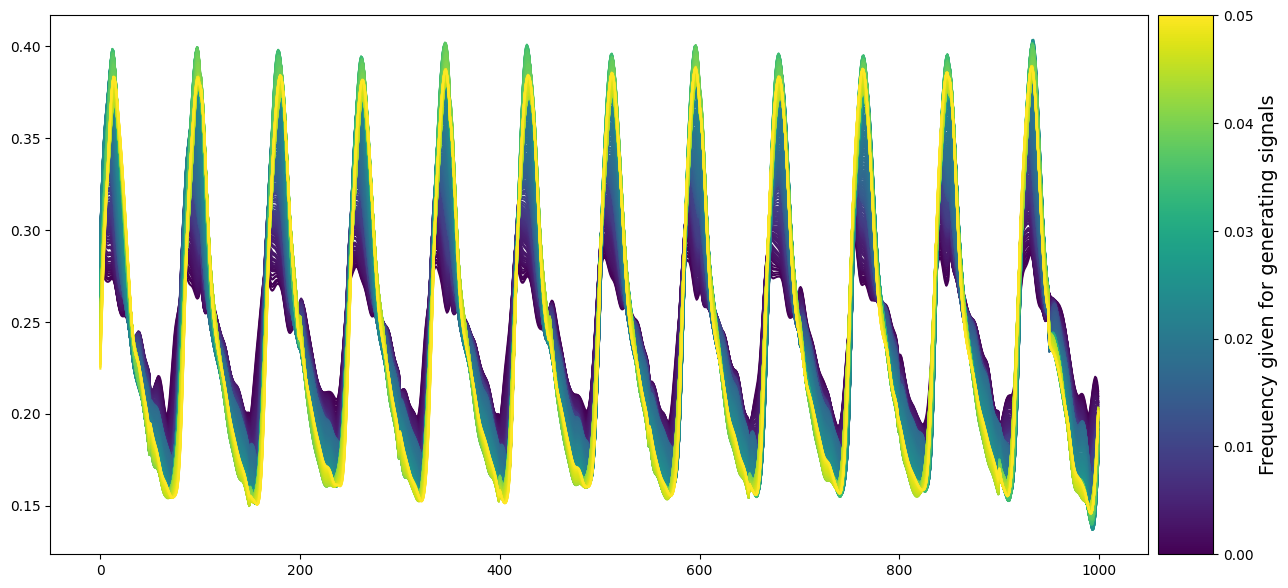

In [39]:
FreqID = 12
ZFixSubID = 0
assert ZFixSubID < len(NestedZFix[FreqID]), 'ZFixSubID must be smaller than ' + str(len(NestedZFix[FreqID]))
RecPred, HH,HL,LH, LL = VisReconGivenZ (FeatGenModel,  ReconModel, LatDim, NestedZFix[FreqID][ZFixSubID], Mode='Origin', N_Gen=300, MinFreqR=0, MaxFreqR=0.05)

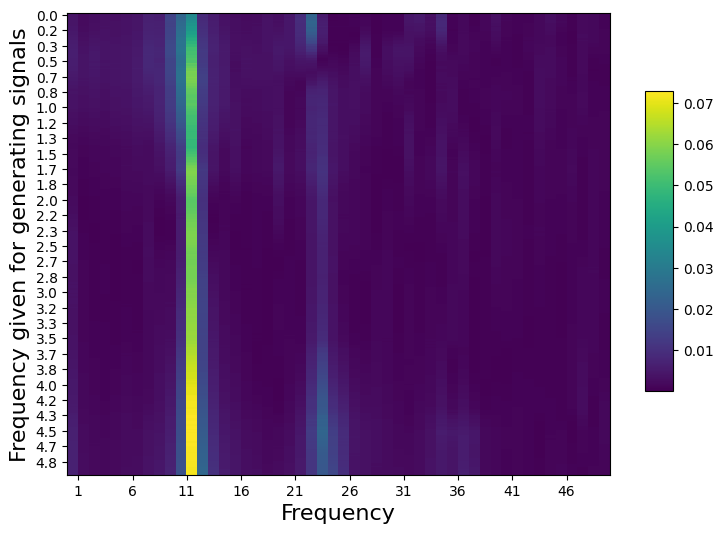

In [49]:
HeatMapFrequency(FeatGenModel,  ReconModel, LatDim, NestedZFix[FreqID][ZFixSubID], N_Gen=300)

In [28]:
ExtSize = 100

In [31]:
## Data
Ext_Samp_Zj = np.tile(Samp_Zj[:, None], (1, ExtSize, 1))
Ext_Samp_FCs = np.random.rand(Ext_Samp_Zj.shape[0],Ext_Samp_Zj.shape[1],6) * FcLimit
#Ext_Samp_FCs = np.tile(np.linspace(1e-7, FcLimit, ExtSize)[None, :, None], (Ext_Samp_Zj.shape[0], 1,6))
Ext_Samp_Zj = np.reshape(Ext_Samp_Zj, (-1, LatDim))
Ext_Samp_FCs = np.reshape(Ext_Samp_FCs, (-1, 6))
GenSamp = GenModel.predict([Ext_Samp_FCs[:, :2], Ext_Samp_FCs[:, 2:], Ext_Samp_Zj], batch_size=1000, verbose=1)

180/180 [==============================] - 5s 30ms/step


(12830, 6)

In [32]:
Samp_FCs = np.random.rand(Samp_Zj.shape[0],6) * FcLimit
GenSamp = GenModel.predict([Samp_FCs[:, :2], Samp_FCs[:, 2:], Samp_Zj], batch_size=1000, verbose=1)

2/2 [==============================] - 0s 34ms/step


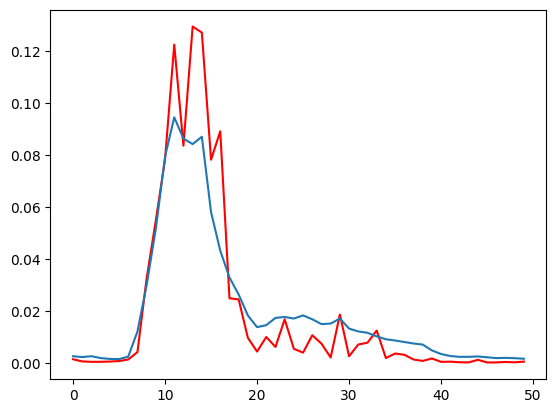

In [33]:
PSEGenSamp =  FFT_PSD(GenSamp, 'All', MinFreq = 1, MaxFreq = 51)
PSEValData =  FFT_PSD(ValData, 'All', MinFreq = 1, MaxFreq = 51)

plt.plot(PSEGenSamp, c='red')
plt.plot(PSEValData)

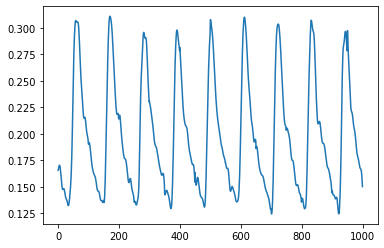

In [199]:
plt.plot(GenSamp[2])